## Get scripts

In [0]:
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/getData.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/constants.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/trainingUtils.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/models.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/analysisFunctions.py

## Get data

In [0]:
from getData import downloadSpeechData, getDataDict

# Download data
downloadSpeechData(data_path='speechData/')

# Get dict with files and labels
dataDict = getDataDict(data_path='speechData/')

Extracting /content/speechData/train.tar.gz into /content/speechData/train
Extracting /content/speechData/test.tar.gz into /content/speechData/test


In [0]:
from getData import getDataframe
import pandas as pd

trainDF = getDataframe(dataDict['train'])
valDF = getDataframe(dataDict['val'])
testDF = getDataframe(dataDict['test'], include_unknown=True) 
finalTestDF = getDataframe(dataDict['finalTest'], include_unknown=True) 

print("Train files: {}".format(trainDF.shape[0]))
print("Validation files: {}".format(valDF.shape[0]))
print("Test files: {}".format(testDF.shape[0]))
print("Final test files: {}".format(finalTestDF.shape[0]))

Train files: 51088
Validation files: 6798
Test files: 6835
Final test files: 3081


In [0]:
trainDF.head()

,files,labels,category
0,speechData/train/no/66cbe2b3_nohash_2.wav,9,no
1,speechData/train/yes/aeb99b1c_nohash_0.wav,28,yes
2,speechData/train/zero/ad1429cf_nohash_0.wav,17,zero
3,speechData/train/yes/6aafb34f_nohash_1.wav,28,yes
4,speechData/train/stop/7014b07e_nohash_1.wav,0,stop


## Install tf 2.0 and other packages

In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 76kB/s 
     |████████████████████████████████| 3.1MB 28.6MB/s 
     |████████████████████████████████| 501kB 27.5MB/s 


In [0]:
import tensorflow as tf

print("GPU Available: ", tf.test.is_gpu_available())
print("Version: ", tf.__version__)

GPU Available:  True
Version:  2.0.0-beta1


In [0]:
!pip install -q python_speech_features

In [0]:
!pip install -q scikit-optimize

     |████████████████████████████████| 81kB 3.0MB/s 


## Train model

In [0]:
tf.keras.backend.clear_session()

def cnnModelv2(input_shape=(99, 40)):
    """
    Model consisting of 4 convolution blocks
    """

    model = tf.keras.models.Sequential()

    # Normalization layer
    model.add(tf.keras.layers.Reshape(input_shape=input_shape, target_shape=(99, 40, 1)))
    model.add(tf.keras.layers.BatchNormalization())

    filters = [16, 32, 64, 128]

    for num_filters in filters:
        # Conv a
        model.add(tf.keras.layers.Conv2D(
            num_filters,
            kernel_size=(3, 3),
            padding='same'
            )
        )
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))

        # Conv b
        model.add(tf.keras.layers.Conv2D(
            num_filters,
            kernel_size=(3, 3),
            padding='same'
            )
        )
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))

        # Pooling
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.2))

    # Classification layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, name='features512'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(256, name='features256'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(30, activation='softmax'))
    
    return model

model = cnnModelv2()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 99, 40, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 99, 40, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 99, 40, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 99, 40, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 99, 40, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 40, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 99, 40, 16)        6

In [0]:
from trainingUtils import getDataset

BATCH_SIZE = 32
# Reduced trainign dataset by using a numer <60k
NUM_EXAMPLES = 100000

train_data, train_steps = getDataset(
    df=trainDF[:NUM_EXAMPLES],
    batch_size=BATCH_SIZE,
    cache_file='train_cache',
    shuffle=True,
    scale=False
) 

val_data, val_steps = getDataset(
    df=valDF,
    batch_size=BATCH_SIZE,
    cache_file='val_cache',
    shuffle=False,
    scale=False
)

In [0]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["sparse_categorical_accuracy"])


EPOCHS = 40

# Stop if the validation accuracy doesn't imporove for 5 epochs
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, verbose=1)

# Reduce LR on Plateau
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

# Save best models
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("cnnv2.h5", monitor='val_sparse_categorical_accuracy', save_best_only=True)

history = model.fit(train_data.repeat(), 
          steps_per_epoch=train_steps,
          validation_data=val_data.repeat(),
          validation_steps=val_steps,
          epochs=EPOCHS,
          callbacks=[earlyStopping, reduceLR, modelCheckpoint])

W0719 09:32:18.556684 140684628252416 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0719 09:32:18.559728 140684628252416 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0719 09:32:18.559440 140684619859712 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0719 09:32:18.563677 140684619859712 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0719 09:32:18.561522 140684628252416 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32


Epoch 1/40


W0719 09:36:55.295732 140686632757120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1596/1596 [==============================] - 424s 265ms/step - loss: 1.5822 - sparse_categorical_accuracy: 0.5499 - val_loss: 0.4154 - val_sparse_categorical_accuracy: 0.8756
Epoch 2/40
1596/1596 [==============================] - 102s 64ms/step - loss: 0.4730 - sparse_categorical_accuracy: 0.8625 - val_loss: 0.2673 - val_sparse_categorical_accuracy: 0.9203
Epoch 3/40
1596/1596 [==============================] - 101s 63ms/step - loss: 0.3438 - sparse_categorical_accuracy: 0.9004 - val_loss: 0.2599 - val_sparse_categorical_accuracy: 0.9245
Epoch 4/40
1596/1596 [==============================] - 100s 63ms/step - loss: 0.2859 - sparse_categorical_accuracy: 0.9177 - val_loss: 0.2130 - val_sparse_categorical_accuracy: 0.9418
Epoch 5/40
1596/1596 [==============================] - 100s 63ms/step - loss: 0.2511 - sparse_categorical_accuracy: 0.9267 - val_loss: 0.2000 - val_sparse_categorical_accuracy: 0.9399
Epoch 6/40
1596/1596 [==============================] - 99s 62ms/step - loss: 0.2216 

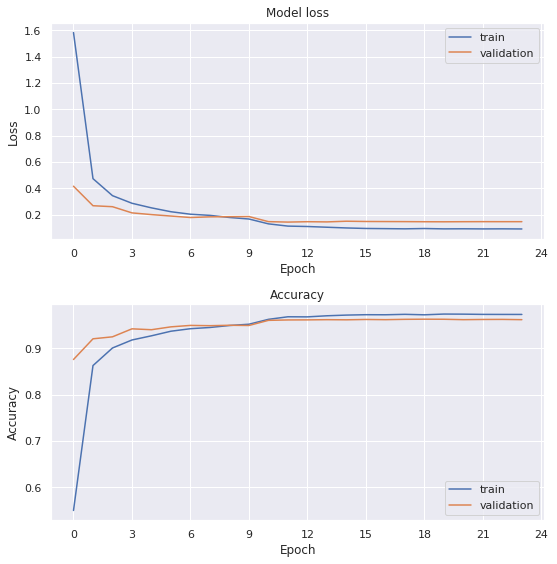

In [0]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns 

sns.set()

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

ax1.plot(loss, label='train')
ax1.plot(val_loss, label='validation')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc, label='train')
ax2.plot(val_acc, label='validation')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
fig.show()

## Load best model

In [0]:
model = tf.keras.models.load_model('cnnv2.h5')

## Save model

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
GDRIVE_PATH = "/content/gdrive/My Drive/speechRecognition/cnnModel/"

model.save(GDRIVE_PATH + "VGG_final_9626.h5")
print("Saved model to drive")

Saved model to drive


In [0]:
import pickle
## Save history data
with open(GDRIVE_PATH + "train_history_VGG_final_9626.pickle", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)    
print("Saved training history to drive")

Saved training history to drive


## Extract features

In [0]:
## load model

model = tf.keras.models.load_model('"/content/gdrive/My Drive/speechRecognition/cnnModel/"cnnv2.h5')

In [0]:
from trainingUtils import getDataset

marvin_data, _ = getDataset(
    df=trainDF.loc[trainDF['category']=='marvin', :],
    batch_size=32,
    cache_file='oc_train_cache',
    shuffle=False
)

In [0]:
valDF['oc_class'] = valDF.apply(lambda row: 1 if row['category']=='marvin' else -1, axis=1)
val_true = valDF['oc_class'].tolist()
valDF.head()

,files,labels,category,oc_class
0,speechData/train/bed/026290a7_nohash_0.wav,16,bed,-1
1,speechData/train/bed/060cd039_nohash_0.wav,16,bed,-1
2,speechData/train/bed/060cd039_nohash_1.wav,16,bed,-1
3,speechData/train/bed/099d52ad_nohash_0.wav,16,bed,-1
4,speechData/train/bed/0e17f595_nohash_0.wav,16,bed,-1


In [0]:
from trainingUtils import _loadWavs, _logMelFilterbank

def _parse_fn(filename):
    wave = _loadWavs(filename)
    fbank = _logMelFilterbank(wave)
    return fbank

In [0]:
def getFeatures(data):
    layer_name = 'features256'
    layer_out = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return layer_out.predict(data, use_multiprocessing=True)

In [0]:
import numpy as np
valData = np.zeros((valDF.shape[0], 99, 40))

for i,f in enumerate(valDF['files']):
    valData[i] = _parse_fn(f)

In [0]:
X_train = getFeatures(marvin_data)
X_val = getFeatures(valData)

## PCA

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=32)

pca.fit(X_train)

print(sum(pca.explained_variance_ratio_)) 

0.9886117635760456


In [0]:
X_train_transformed = pca.transform(X_train)
X_val_transformed = pca.transform(X_val)

In [0]:
from skopt.space import Real
from skopt.utils import use_named_args

from sklearn.metrics import f1_score
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')

oc_svm = svm.OneClassSVM()

space_svm  = [
    Real(10**-5, 10**0, "log-uniform", name='gamma'),
    Real(10**-5, 10**0, "log-uniform", name='nu')
]

@use_named_args(space_svm)
def objective_svm(**params):
    oc_svm.set_params(**params)
    
    oc_svm.fit(X_train_transformed)
    val_pred = oc_svm.predict(X_val_transformed)
    
    score = f1_score(val_pred, val_true)
   

    return -1*score

In [184]:
from skopt import gp_minimize

res_gp_svm = gp_minimize(objective_svm, space_svm, n_calls=100, n_jobs=-1, verbose=False, random_state=1) 
print("Best score={:.4f}".format(-res_gp_svm.fun))

Best score=0.9778


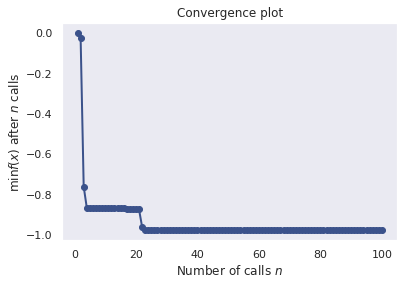

In [185]:
from skopt.plots import plot_convergence

ax = plot_convergence(res_gp_svm)
plt.show()

In [186]:
best_parameters_svm = {k.name: x for k, x in zip(space_svm, res_gp.x)}
best_parameters_svm

{'gamma': 2.7410027556477743e-05, 'nu': 0.0157877607403341}

Accuracy: 0.9990
Precision: 0.9935
Recal: 0.9625
F1-score: 0.9778


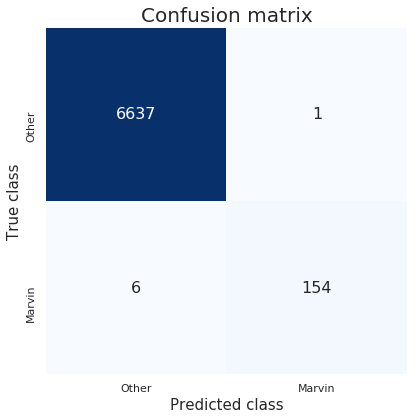

In [187]:
from analysisFunctions import showResultsOC

bestOC = svm.OneClassSVM().set_params(**best_parameters_svm)

bestOC.fit(X_train_transformed)

val_pred = bestOC.predict(X_val_transformed)
showResultsOC(val_pred, val_true)

In [0]:
from skopt import dummy_minimize

res_random = dummy_minimize(objective, space, n_calls=100, verbose=False, random_state=100)
print("Best score={:.4f}".format(-res_random.fun))

Best score=0.9659


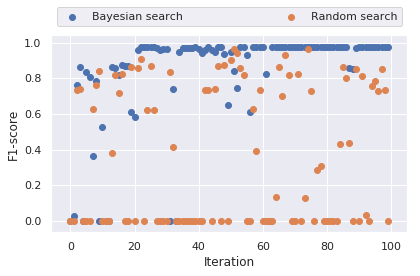

In [188]:
gp_val = -1*np.asarray(res_gp_svm.func_vals)
random_val = -1*np.asarray(res_random.func_vals)

fig = plt.figure()
plt.scatter(range(len(gp_val)), gp_val, label='Bayesian search')
plt.scatter(range(len(random_val)), random_val, label='Random search')
plt.xlabel("Iteration")
plt.ylabel("F1-score")
plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode='expand', ncol=2)
plt.tight_layout()
fig.show()

## Isolation Forest

In [0]:
from sklearn.ensemble import IsolationForest
from skopt.space import Real, Integer, Categorical


isf = IsolationForest(random_state=42, bootstrap='True')

space_isf  = [
    Integer(1, 200, name='n_estimators'),
    Integer(10, 300, name='max_samples'),
    Real(10**-5, 10**0, "log-uniform", name='contamination'),
    Real(0.01, 1, name='max_features')
]

@use_named_args(space_isf)
def objective_isf(**params):
    isf.set_params(**params)
    
    isf.fit(X_train)
    val_pred = isf.predict(X_val)
    
    score = f1_score(val_pred, val_true)
   

    return -1*score

In [190]:
from skopt import gp_minimize

res_gp_isf = gp_minimize(objective_isf, space_isf, n_calls=100, n_jobs=-1, verbose=False, random_state=100)
print("Best score={:.4f}".format(-res_gp_isf.fun))

Best score=0.9841


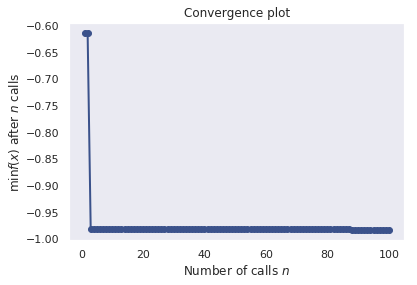

In [191]:
from skopt.plots import plot_convergence

ax = plot_convergence(res_gp_isf)
plt.show()

In [193]:
best_parameters_isf = {k.name: x for k, x in zip(space_isf, res_gp_isf.x)}
best_parameters_isf

{'contamination': 0.012750505239697046,
 'max_features': 0.01,
 'max_samples': 132,
 'n_estimators': 156}

Accuracy: 0.9993
Precision: 1.0000
Recal: 0.9688
F1-score: 0.9841


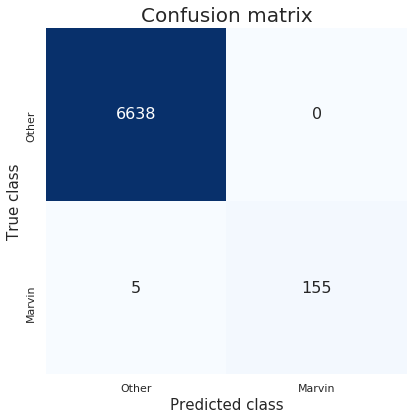

In [194]:
bestisf = IsolationForest(random_state=42, bootstrap='True').set_params(**best_parameters_isf)

bestisf.fit(X_train)

val_pred = bestisf.predict(X_val)
showResultsOC(val_pred, val_true)

## Final tests

In [0]:
import pandas as pd 

dfTest = pd.concat([testDF,finalTestDF],ignore_index=True)

In [0]:
testData = np.zeros((dfTest.shape[0], 99, 40))

for i,f in enumerate(dfTest['files']):
    testData[i] = _parse_fn(f)
    
X_test = getFeatures(testData)

In [0]:
dfTest['oc_class'] = dfTest.apply(lambda row: 1 if row['category']=='marvin' else -1, axis=1)
test_true = dfTest['oc_class'].tolist()
dfTest.loc[dfTest['category']=='_background_noise_', :].head()

,files,labels,category,oc_class
9135,speechData/test/_unknown_/four_37dca74f_nohash...,30,_background_noise_,-1
9136,speechData/test/_unknown_/two_fce96bac_nohash_...,30,_background_noise_,-1
9137,speechData/test/_unknown_/bed_6205088b_nohash_...,30,_background_noise_,-1
9138,speechData/test/_unknown_/three_adebe223_nohas...,30,_background_noise_,-1
9139,speechData/test/_unknown_/four_105a0eea_nohash...,30,_background_noise_,-1


Accuracy: 0.9980
Precision: 0.9277
Recal: 0.9506
F1-score: 0.9390


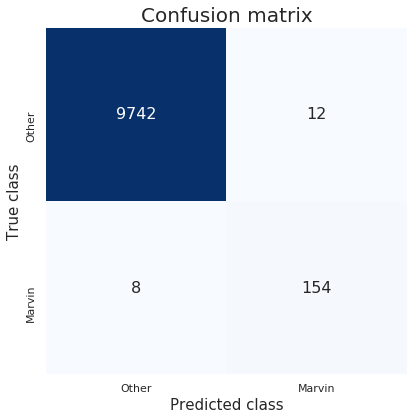

In [163]:
X_test_scaled = pca.transform(X_test)

test_pred = bestOC.predict(X_test_scaled)
showResultsOC(test_pred, test_true)

Accuracy: 0.9980
Precision: 0.9277
Recal: 0.9506
F1-score: 0.9390


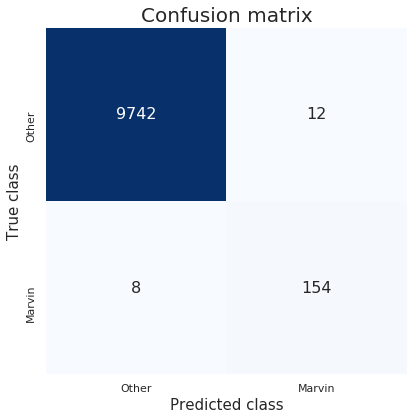

In [195]:
test_pred = bestisf.predict(X_test)
showResultsOC(test_pred, test_true)